<h1><strong>Stacking Classifier</strong> </h1> 
    
<h3>Acá se va a estar probando el ensamblaje de Stacking con los distintos algoritmos implementados.</h3>

Primero se hacen los imports necesarios

In [32]:
import pandas as pd
import numpy as np
import nbimporter # pip install nbimporter
import matplotlib.pyplot as plt
import seaborn as sn

import sklearn

from sklearn import svm
from catboost import CatBoostClassifier # pip install catboost
from lightgbm import LGBMClassifier  #pip install lightgbm
from xgboost import XGBClassifier #pip install xgboost
from sklearn.naive_bayes  import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import StackingClassifier, BaggingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix


from feature_builder import process_dataset
from Exporter import export_model_csv
from hyperparameter_tunning import obtener_hiperparametros

hyper_params = obtener_hiperparametros()

In [2]:
train_dataset = pd.read_csv('train.csv')

In [3]:
test_dataset = pd.read_csv('test.csv')

In [4]:
y = train_dataset.loc[:,'target']

<h2><strong>Preparo los distintos sets con features diferentes.</h2>
Los distintos algoritmos necesitan diferentes sets, según lo investigado.

Primero los procesados completos con spacy

In [5]:
x_processed = process_dataset(train_dataset, use_spacy=True)

Embeddings loaded!
Percentage of words covered in the embeddings = 0.4937444933920705
Embeddings loaded!
Percentage of words covered in the embeddings = 0.5961027457927369


In [42]:
x_train_processed, x_test_processed, y_train_processed, y_test_processed = train_test_split(x_processed, y,
                                                                                     test_size = .30, random_state = 17)

Ahora los que solo necesitan embeddings. 

In [7]:
x_embedd = process_dataset(train_dataset, use_spacy=True, use_manual_features=False)

Embeddings loaded!
Percentage of words covered in the embeddings = 0.4937444933920705
Embeddings loaded!
Percentage of words covered in the embeddings = 0.5961027457927369


In [8]:
x_train_embedd, x_test_embedd, y_train_embedd, y_test_embedd = train_test_split(x_embedd, y, test_size = .30,
                                                                                random_state = 17)

<h2><strong> Defino los algoritmos a usar
    

In [9]:
logisticRegr = LogisticRegression(solver='liblinear', penalty='l1', multi_class='auto', max_iter=1000, C=1)

In [10]:
SVC = svm.SVC(degree=10,coef0=10,C=5, probability=True)

In [11]:
catboost = CatBoostClassifier(verbose=False)

In [ ]:
BC_CB = BaggingClassifier(base_estimator= catboost, n_estimators=10, random_state=0)

In [12]:
MultiNB = MultinomialNB()

In [13]:
xgbooster = XGBClassifier(max_depth=3, n_estimators=600, colsample_bytree=0.9,
  subsample=0.9, nthread=4, learning_rate=0.05)

In [14]:
gbm = LGBMClassifier()

<h2><strong> Les aplicamos bagging
    

In [43]:
BC_LR = BaggingClassifier(base_estimator= logisticRegr, n_estimators=10, random_state=0)

In [44]:
BC_SVC = BaggingClassifier(base_estimator= SVC, n_estimators=10, random_state=0)

In [45]:
BC_CB = BaggingClassifier(base_estimator= catboost, n_estimators=10, random_state=0)

In [ ]:
BC_XGB = BaggingClassifier(base_estimator= xgbooster, n_estimators=10, random_state=0)

In [ ]:
BC_LGB = BaggingClassifier(base_estimator= gbm, n_estimators=10, random_state=0)

<h1><strong> Empiezo las pruebas

------------------------------------------------------------------------------------------------------
<h3>PODRIAMOS PROBAR UNO QUE HAGA TODAS LAS COMBINACIONES Y DEVUELVA EL MEJOR, QUIEN SE ANIMA</h3>
----------------------------------------------------------------------------------------------------------------

<h3> Logistic, SVC, CatBoost, BC_XGB, BC_LGB

In [15]:
SC_LSXLC = StackingClassifier(estimators=[('lr', logisticRegr), ('svc', SVC),('bc_xgb',BC_XGB),
                                          ('bc_lgb',BC_LGB)], final_estimator = catboost )

In [16]:
SC_LSXLC.fit(x_train_processed, y_train_processed)

StackingClassifier(cv=None,
                   estimators=[('lr',
                                LogisticRegression(C=1, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=1000,
                                                   multi_class='auto',
                                                   n_jobs=None, penalty='l1',
                                                   random_state=None,
                                                   solver='liblinear',
                                                   tol=0.0001, verbose=0,
                                                   warm_start=False)),
                               ('svc',
                                SVC(C=5, break_ties=False, cache_size=200,
                       

In [17]:
y_pred_processed_LSC = SC_LSXLC.predict(x_test_processed)

In [18]:
f1_score(y_test_processed, y_pred_processed_LSC)

0.7867247007616975

<h3> Logistic, SVC, CatBoost

In [46]:
SC_LSC = StackingClassifier(estimators=[('BC_LR', BC_LR), ('BC_SVC', BC_SVC), ('BC_CB', BC_CB)])

Pruebo procesadas

In [ ]:
SC_LSC.fit(x_train_processed, y_train_processed)

In [ ]:
y_pred_processed_LSC = SC_LSC.predict(x_test_processed)

In [ ]:
f1_score(y_test_processed, y_pred_processed_LSC)

In [ ]:
0.7993647432503971

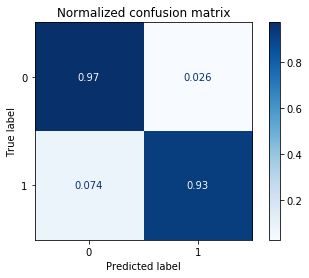

In [41]:
disp = plot_confusion_matrix(SC_LSC, x_test_processed, y_test_processed,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Normalized confusion matrix')
plt.show()

<h3> Logistic, CatBoost

In [56]:
SC_LC = StackingClassifier(estimators=[('lr', logisticRegr), ('catboost', catboost)])

Pruebo procesadas

In [57]:
SC_LC.fit(x_train_processed, y_train_processed)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l1',
                                                 random_state=None,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7f3591d35850>)],
                 flatten_transform=True, n_jobs=None, voting='hard',
                 weights=None)

In [58]:
y_pred_processed_LC = SC_LC.predict(x_test_processed)

In [59]:
f1_score(y_test_processed, y_pred_processed_LC)

0.7770915216170691

<h2>Paso a exportar el mejor resultado

In [23]:
x_train_final = process_dataset(train_dataset, use_spacy=True)

Embeddings loaded!
Percentage of words covered in the embeddings = 0.4937444933920705
Embeddings loaded!
Percentage of words covered in the embeddings = 0.5961027457927369


In [24]:
x_test_final = process_dataset(test_dataset, use_spacy=True)

Embeddings loaded!
Percentage of words covered in the embeddings = 0.5707598689343111
Embeddings loaded!
Percentage of words covered in the embeddings = 0.665389037945573


In [25]:
export_model_csv(SC_LSC, x_train_final, x_test_final, test_dataset, y, 'SC-LSC-processed.csv')